In [1]:
#Config
ProjectID="datawx"
queryFile="c:\\temp\\query.txt"
targetDataset="DATASCIENCE_SOURCEDATA"
serviceAcct="C:\\code\\datawx\\abbykatdev.json"
FileType="CoronaTest"

In [4]:
#DataScience DataSource / data helper classes
#(see GCPMLOps.py as this is copied and pasted in here!)

import pandas as pd
import numpy as np
import uuid

class SimpleTimer():
    def __init__(self, name):
        self.name = name
        self.start = pd.Timestamp.now()
        print("Starting " + self.name + " at " + str(self.start))

    def Stop(self):
        self.end = pd.Timestamp.now()
        print("Stopping " + self.name + " at " + str(self.end))
        print("Elapsed time for " + self.name + " is " + str(self.end - self.start))
    
    def GetElalpsed(self):
        return self.end - self.start

class DataSource():

    def __init__(self,ProjectID,filetype,sourceEnvironment,ExtractQuery):
        self.guid = str(uuid.uuid4())
        self.filetype = filetype
        self.ProjectID = ProjectID
        self.sourceEnvironment = sourceEnvironment
        self.ExtractQuery = ExtractQuery
        self.loadedDate = pd.Timestamp.now()
        self.TargetTable =filetype + "_" + self.loadedDate.strftime("%Y_%m_%d") + "_" + self.guid
        
    def WriteEntry(self):
        print("Writing Entry")
        self.WriteToBQ()

    def WriteToBQ(self):        
        frame=[{"Filetype":self.filetype,
            "LoadedDate":self.loadedDate,
            "SourceEnvironment":self.sourceEnvironment,
            "ExtractQuery":self.ExtractQuery,
            "TargetTable":self.TargetTable,
            "GUID":self.guid}]
        #print(frame)
        df = pd.DataFrame(frame)
        df.to_gbq("DATASCIENCE_SOURCEDATA._datasources", project_id=self.ProjectID, if_exists='append')

    @staticmethod    
    def GetLatest(ProjectID,fileType):
        query="""SELECT * FROM `datawx.DATASCIENCE_SOURCEDATA._datasources`
            where Filetype="{0}"
            order by LoadedDate desc
            limit 1""".format(fileType)

        #Get first row
        df = pd.read_gbq(query, project_id=ProjectID)
        row = df.iloc[0]
        source=DataSource(ProjectID,row["Filetype"],row["SourceEnvironment"],row["ExtractQuery"])
        source.loadedDate=row["LoadedDate"]
        source.TargetTable=row["TargetTable"]
        return source

# class TrainingMetrics():

#     @staticmethod
#     def SaveMetrics(self,ExperimentName,ModelName,ModelVersion,ModelType,trainingTime:SimpleTimer):


In [48]:
#Simple SKLearn example with a Decision Tree
#Demonstrates the training of a very simple ML model and how the helper classes can be used to store the results
#Config:
MaxEpochs=10

import warnings
warnings.filterwarnings("ignore")

# load libraries
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

# Load data
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Create list of target class names
class_names = iris.target_names

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Create DecisionTree model
max_depth_list = range(1,MaxEpochs+1)

train_errors = [] # Log training errors for each model
test_errors = [] # Log testing errors for each model

#accuracy_score = None #[] #lambda y, y_hat: np.mean(y == y_hat) # Define accuracy score
for x in max_depth_list:
    dtc = DecisionTreeClassifier(max_depth=x) 
    dtc.fit(X_train,y_train)
    train_z = dtc.predict(X_train)
    test_z = dtc.predict(X_test)

    train_errors.append(accuracy_score(y_train, train_z))
    test_errors.append(accuracy_score(y_test, test_z))



#Create a classification report
print()
print(classification_report(y_test, test_z, target_names=class_names))

#Create a confusion matrix
print()
print(confusion_matrix(y_test, test_z))



              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.87      0.76      0.81        17
   virginica       0.80      0.89      0.84        18

    accuracy                           0.88        50
   macro avg       0.89      0.88      0.88        50
weighted avg       0.88      0.88      0.88        50



[Text(0, 0.5, 'setosa'), Text(0, 1.5, 'versicolor'), Text(0, 2.5, 'virginica')]

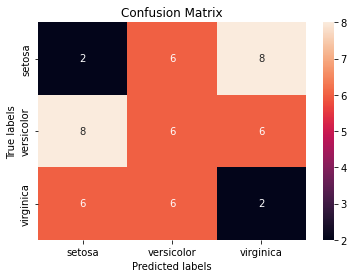

In [39]:
#Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_hat)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names)



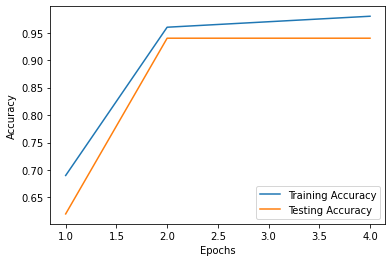

In [34]:

x = np.arange(len(max_depth_list)) + 1 # Create domain for plot
plt.plot(x, train_errors, label='Training Accuracy') # Plot training error over domain
plt.plot(x, test_errors, label='Testing Accuracy') # Plot testing error over domain
plt.xlabel('Epochs') # Label x-axis
plt.ylabel('Accuracy') # Label y-axis
plt.legend() # Show plot labels as legend
plt.show() # Show graph